# <center> Análisis del GP de Australia de F1 

### Resumen del Gran Premio

**Verstappen logra su primera victoria en el GP de Australia en medio de un gran drama en Melbourne**

Max Verstappen se adjudicó la victoria durante un Gran Premio de Australia salvaje y lleno de acción, superando batallas con los pilotos de Mercedes, varios Safety Cars y tres banderas rojas para llevar a casa a Lewis Hamilton y Fernando Alonso.

Verstappen perdió ante George Russell y Hamilton en el inicio original de la carrera, antes de que el Safety Car hiciera dos apariciones en rápida sucesión debido a que Charles Leclerc se retiró de una colisión con Lance Stroll y Alex Albon chocando fuertemente.

<img src="img/au23-preview.png">

- Fuente: https://press.pirelli.com/

### Contexto

Con esta práctica mostramos la importancia de los datos cuando pueden ser recogidos y analizados, utilizar el volumen, la variedad y la velocidad de los datos que genera el vehículo, y convertirlos en una ventaja competitiva.

La Fórmula 1 es uno de los deportes más competitivos y en los que mayor cantidad de tecnología se utiliza en el mundo.

### Objetivo

Utilizaremos el lenguaje **Python** para analizar la telemetría de los pilotos. Seleccionaremos los datos y en el análisis final nos centraremos en la última vuelta y para conocer de manera visual donde estuvieron las claves de la superioridad de Verstappen frente a sus contrincantes de la parrilla.

#### Cargamos las librerias necesarias

In [1]:
import numpy as np
import pandas as pd
import requests

import fastf1 as ff1
import fastf1.plotting
from fastf1.core import Laps
from fastf1 import utils

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from matplotlib import cm

from timple.timedelta import strftimedelta
import warnings

In [2]:
# Configurar gráficos
ff1.plotting.setup_mpl()

# Habilitamos el cache en nuestro equipo
ff1.Cache.enable_cache('cache') 

# Ignoramos los Warning
warnings.filterwarnings("ignore") 

#### Cargamos los datos de la carrera en Australia 2023

**Parámetros de la sesión**
- Año
- Circuito
- Tipo de dato
    - R: Datos de la carrera
    - Q: Datos de la clasificación

In [3]:
# Cargamos la carrera
race = ff1.get_session(2023, 'Australia', 'R')
race.load()

core           INFO 	Loading data for Australian Grand Prix - Race [v2.3.2]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '14', '18', '11', '4', '27', '81', '24', '22', '77', '55', '10', '31', '21', '2', '20', '63', '23', '16']


#### Necesitamos cargar los datos de cada vuelta con su telemetría para el posterior análisis

In [4]:
# Get the laps
laps_r = race.load_laps(with_telemetry=True)

core           INFO 	Loading data for Australian Grand Prix - Race [v2.3.2]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '14', '18', '11', '4', '27', '81', '24', '22', '77', '55', '10', '31', '21', '2', '20', '63', '23', '16']


#### Obtenemos la siguiente información por vuelta (una columna de DataFrame para cada uno)

- Time (pandas.Timedelta): Session time when the lap time was set (end of lap)

- Driver (string): Three letter driver identifier

- DriverNumber (str): Driver number

- LapTime (pandas.Timedelta): Recorded lap time. Officially deleted lap times will not be deleted here. Deleting laps is currently not supported.

- LapNumber (int): Recorded lap number

- Stint (int): Stint number

- PitOutTime (pandas.Timedelta): Session time when car exited the pit

- PitInTime (pandas.Timedelta): Session time when car entered the pit

- Sector1Time (pandas.Timedelta): Sector 1 recorded time

- Sector2Time (pandas.Timedelta): Sector 2 recorded time

- Sector3Time (pandas.Timedelta): Sector 3 recorded time

- Sector1SessionTime (pandas.Timedelta): Session time when the Sector 1 time was set

- Sector2SessionTime (pandas.Timedelta): Session time when the Sector 2 time was set

- Sector3SessionTime (pandas.Timedelta): Session time when the Sector 3 time was set

- SpeedI1 (float): Speedtrap sector 1 [km/h]

- SpeedI2 (float): Speedtrap sector 2 [km/h]

- SpeedFL (float): Speedtrap at finish line [km/h]

- SpeedST (float): Speedtrap on longest straight (Not sure) [km/h]

- IsPersonalBest (bool): Flag that indicates whether this lap is the official personal best lap of a driver. If any lap of a driver is quicker than their respective personal best lap, this means that the quicker lap is invalid and not counted. This can happen it the track limits were execeeded, for example.

- Compound (str): Tyres event specific compound name: SOFT, MEDIUM, HARD, INTERMEDIATE, WET (the actual underlying compounds C1 to C5 are not differentiated).

- TyreLife (float): Laps driven on this tire (includes laps in other sessions for used sets of tires)

- FreshTyre (bool): Tyre had TyreLife=0 at stint start, i.e. was a new tire

- Team (str): Team name

- LapStartTime (pandas.Timedelta): Session time at the start of the lap

- LapStartDate (pandas.Timestamp): Timestamp at the start of the lap

- TrackStatus (str): A string that contains track status numbers for all track status that occurred during this lap. The meaning of the track status numbers is explained in fastf1.api.track_status_data(). For filtering laps by track status, you may want to use Laps.pick_track_status().

- IsAccurate (bool): Indicates that the lap start and end time are synced correctly with other laps. Do not confuse this with the accuracy of the lap time or sector times. They are always considered to be accurate if they exist! If this value is True, the lap has passed as basic accuracy check for timing data. This does not guarantee accuracy but laps marked as inaccurate need to be handled with caution. They might contain errors which can not be spotted easily. Laps need to satisfy the following criteria to be marked as accurate:

In [5]:
laps_r.head()

,Time,DriverNumber,LapTime,LapNumber,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,...,Compound,TyreLife,FreshTyre,Stint,LapStartTime,Team,Driver,TrackStatus,IsAccurate,LapStartDate
0,0 days 01:03:58.732000,1,NaT,1.0,0 days 00:23:26.593000,NaT,NaT,0 days 00:00:18.707000,0 days 00:00:46.357000,NaT,...,MEDIUM,1.0,True,1,0 days 01:02:16.863000,Red Bull Racing,VER,24,False,2023-04-02 05:03:18.685
1,0 days 01:06:10.837000,1,0 days 00:02:12.105000,2.0,NaT,NaT,0 days 00:00:48.846000,0 days 00:00:31.614000,0 days 00:00:51.645000,0 days 01:04:47.578000,...,MEDIUM,2.0,True,1,0 days 01:03:58.732000,Red Bull Racing,VER,4,False,2023-04-02 05:05:00.554
2,0 days 01:08:21.494000,1,0 days 00:02:10.657000,3.0,NaT,NaT,0 days 00:00:46.836000,0 days 00:00:29.178000,0 days 00:00:54.643000,0 days 01:06:57.673000,...,MEDIUM,3.0,True,1,0 days 01:06:10.837000,Red Bull Racing,VER,4,False,2023-04-02 05:07:12.659
3,0 days 01:09:44.885000,1,0 days 00:01:23.391000,4.0,NaT,NaT,0 days 00:00:28.900000,0 days 00:00:18.326000,0 days 00:00:36.165000,0 days 01:08:50.394000,...,MEDIUM,4.0,True,1,0 days 01:08:21.494000,Red Bull Racing,VER,1,False,2023-04-02 05:09:23.316
4,0 days 01:11:07.989000,1,0 days 00:01:23.104000,5.0,NaT,NaT,0 days 00:00:28.935000,0 days 00:00:18.347000,0 days 00:00:35.822000,0 days 01:10:13.820000,...,MEDIUM,5.0,True,1,0 days 01:09:44.885000,Red Bull Racing,VER,1,True,2023-04-02 05:10:46.707


#### Accedemos a los datos metereológicos del día de carrera con el método *session.weather_data*

In [6]:
session = fastf1.get_session(2023, 'Australia', 'R')
session.load(telemetry=False)
weather_data = session.laps.get_weather_data()
weather_data.head()

core           INFO 	Loading data for Australian Grand Prix - Race [v2.3.2]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '14', '18', '11', '4', '27', '81', '24', '22', '77', '55', '10', '31', '21', '2', '20', '63', '23', '16']


,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
62,0 days 01:02:35.816000,17.4,52.0,1018.5,False,34.6,149,1.0
64,0 days 01:04:35.814000,17.5,53.0,1018.5,False,34.2,127,0.6
66,0 days 01:06:35.813000,17.6,53.0,1018.7,False,34.2,138,1.2
68,0 days 01:08:35.812000,17.8,52.0,1018.5,False,34.4,0,0.8
70,0 days 01:10:35.810000,17.8,52.0,1018.5,False,34.0,163,1.2


#### Unión de datos meteorológicos con datos de tiempo de vuelta:

In [7]:
# prepare the data for joining
laps = session.laps
laps = laps.reset_index(drop=True)
weather_data = weather_data.reset_index(drop=True)

# exclude the 'Time' column from weather data when joining
joined = pd.concat([laps, weather_data.loc[:, ~(weather_data.columns == 'Time')]], axis=1)
joined.head()

,Time,DriverNumber,LapTime,LapNumber,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,...,Driver,TrackStatus,IsAccurate,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 01:03:58.732000,1,NaT,1.0,0 days 00:23:26.593000,NaT,NaT,0 days 00:00:18.707000,0 days 00:00:46.357000,NaT,...,VER,24,False,17.4,52.0,1018.5,False,34.6,149,1.0
1,0 days 01:06:10.837000,1,0 days 00:02:12.105000,2.0,NaT,NaT,0 days 00:00:48.846000,0 days 00:00:31.614000,0 days 00:00:51.645000,0 days 01:04:47.578000,...,VER,4,False,17.5,53.0,1018.5,False,34.2,127,0.6
2,0 days 01:08:21.494000,1,0 days 00:02:10.657000,3.0,NaT,NaT,0 days 00:00:46.836000,0 days 00:00:29.178000,0 days 00:00:54.643000,0 days 01:06:57.673000,...,VER,4,False,17.6,53.0,1018.7,False,34.2,138,1.2
3,0 days 01:09:44.885000,1,0 days 00:01:23.391000,4.0,NaT,NaT,0 days 00:00:28.900000,0 days 00:00:18.326000,0 days 00:00:36.165000,0 days 01:08:50.394000,...,VER,1,False,17.8,52.0,1018.5,False,34.4,0,0.8
4,0 days 01:11:07.989000,1,0 days 00:01:23.104000,5.0,NaT,NaT,0 days 00:00:28.935000,0 days 00:00:18.347000,0 days 00:00:35.822000,0 days 01:10:13.820000,...,VER,1,True,17.8,52.0,1018.5,False,34.0,163,1.2


#### Visión general de los pilotos y sus vueltas rápidas durante la carrera

In [8]:
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, color_scheme=None, misc_mpl_mods=False)

session = fastf1.get_session(2023, 'Australia', 'R')
session.load()

core           INFO 	Loading data for Australian Grand Prix - Race [v2.3.2]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '14', '18', '11', '4', '27', '81', '24', '22', '77', '55', '10', '31', '21', '2', '20', '63', '23', '16']


#### Necesitamos obtener un array de todos los pilotos

In [9]:
drivers = pd.unique(session.laps['Driver'])
print(drivers)

['VER' 'HAM' 'ALO' 'STR' 'PER' 'NOR' 'HUL' 'PIA' 'ZHO' 'TSU' 'BOT' 'SAI'
 'GAS' 'OCO' 'DEV' 'SAR' 'MAG' 'RUS' 'ALB' 'LEC']


#### Después obtendremos la vuelta más rápida de cada piloto

In [10]:
list_fastest_laps = list()
for drv in drivers:
    drvs_fastest_lap = session.laps.pick_driver(drv).pick_fastest()
    list_fastest_laps.append(drvs_fastest_lap)
fastest_laps = Laps(list_fastest_laps).sort_values(by='LapTime').reset_index(drop=True)

In [11]:
pole_lap = fastest_laps.pick_fastest()
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']

In [12]:
print(fastest_laps[['Driver', 'LapTime', 'LapTimeDelta']])

   Driver                LapTime           LapTimeDelta
0     PER 0 days 00:01:20.235000        0 days 00:00:00
1     VER 0 days 00:01:20.342000 0 days 00:00:00.107000
2     SAI 0 days 00:01:20.467000 0 days 00:00:00.232000
3     ALO 0 days 00:01:20.476000 0 days 00:00:00.241000
4     HAM 0 days 00:01:20.613000 0 days 00:00:00.378000
5     STR 0 days 00:01:20.934000 0 days 00:00:00.699000
6     GAS 0 days 00:01:20.995000 0 days 00:00:00.760000
7     HUL 0 days 00:01:21.124000 0 days 00:00:00.889000
8     NOR 0 days 00:01:21.173000 0 days 00:00:00.938000
9     DEV 0 days 00:01:21.183000 0 days 00:00:00.948000
10    OCO 0 days 00:01:21.203000 0 days 00:00:00.968000
11    PIA 0 days 00:01:21.335000 0 days 00:00:01.100000
12    SAR 0 days 00:01:21.456000 0 days 00:00:01.221000
13    MAG 0 days 00:01:21.685000 0 days 00:00:01.450000
14    TSU 0 days 00:01:21.789000 0 days 00:00:01.554000
15    ZHO 0 days 00:01:21.819000 0 days 00:00:01.584000
16    BOT 0 days 00:01:22.233000 0 days 00:00:01

#### Finalmente, crearemos una lista de colores de equipo por vuelta

In [13]:
team_colors = list()
for index, lap in fastest_laps.iterlaps():
    if pd.notnull(lap['Team']):
        color = fastf1.plotting.team_color(lap['Team'])
        team_colors.append(color)

#### Ahora, podemos graficar todos los datos

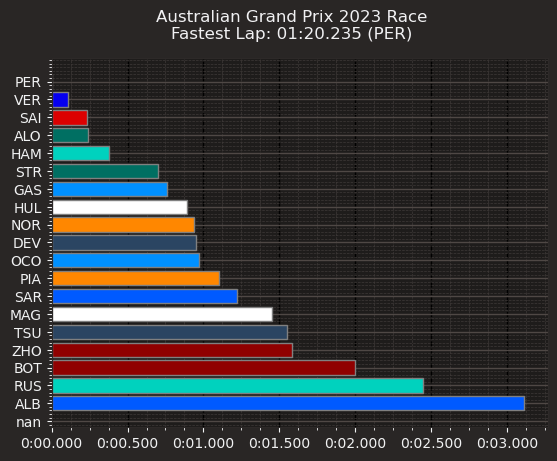

In [14]:
fig, ax = plt.subplots()
ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
        color=team_colors, edgecolor='grey')
ax.set_yticks(fastest_laps.index)
ax.set_yticklabels(fastest_laps['Driver'])

# show fastest at the top
ax.invert_yaxis()

# draw vertical lines behind the bars
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)

lap_time_string = strftimedelta(pole_lap['LapTime'], '%m:%s.%ms')

plt.suptitle(f"{session.event['EventName']} {session.event.year} Race\n"
             f"Fastest Lap: {lap_time_string} ({pole_lap['Driver']})")

plt.show()

Sergio Pérez consiguió la vuelta rápida durante la carrera, aún así el piloto neerlandés Max Verstappen consiguió el triunfo en el Gran Premio de Australia y amplió su ventaja sobre el mexicano. ¿Que fué lo que llevo a Max Verstappen a hacerse con el triunfo? Comparamos a estos dos pilotos y la telemetría de sus vehículos.

### <center> Análisis final con datos de telemetría

#### Obtenemos los siguientes datos

- Car data:

     - Speed (float): Car speed [km/h]

     - RPM (int): Car RPM

     - nGear (int): Car gear number

     - Throttle (float): 0-100 Throttle pedal pressure [%]

     - Brake (bool): Brakes are applied or not.

     - DRS (int): DRS indicator (See fastf1.api.car_data() for more info)

- Position data:

    - X (float): X position [1/10 m]

    - Y (float): Y position [1/10 m]

    - Z (float): Z position [1/10 m]

    - Status (string): Flag - OffTrack/OnTrack


- For both of the above:

   - Time (timedelta): Time (0 is start of the data slice)

   - SessionTime (timedelta): Time elapsed since the start of the session

   - Date (datetime): The full date + time at which this sample was created

   - Source (str): Flag indicating how this sample was created:

   - ‘car’: sample from original api car data

   - ‘pos’: sample from original api position data

   - ‘interpolated’: this sample was artificially created; all values are computed/interpolated

#### Visualización de velocidad de Verstappen en el mapa del circuito de Melbourne

In [15]:
year = 2023
wknd = 3
ses = 'R'
driver = 'VER'
colormap = mpl.cm.plasma

In [16]:
session = ff1.get_session(year, wknd, ses)
weekend = session.event
session.load()
lap = session.laps.pick_driver(driver).pick_fastest()

# Get telemetry data
x = lap.telemetry['X']              # values for x-axis
y = lap.telemetry['Y']              # values for y-axis
color = lap.telemetry['Speed']      # value to base color gradient on

core           INFO 	Loading data for Australian Grand Prix - Race [v2.3.2]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '14', '18', '11', '4', '27', '81', '24', '22', '77', '55', '10', '31', '21', '2', '20', '63', '23', '16']


In [17]:
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

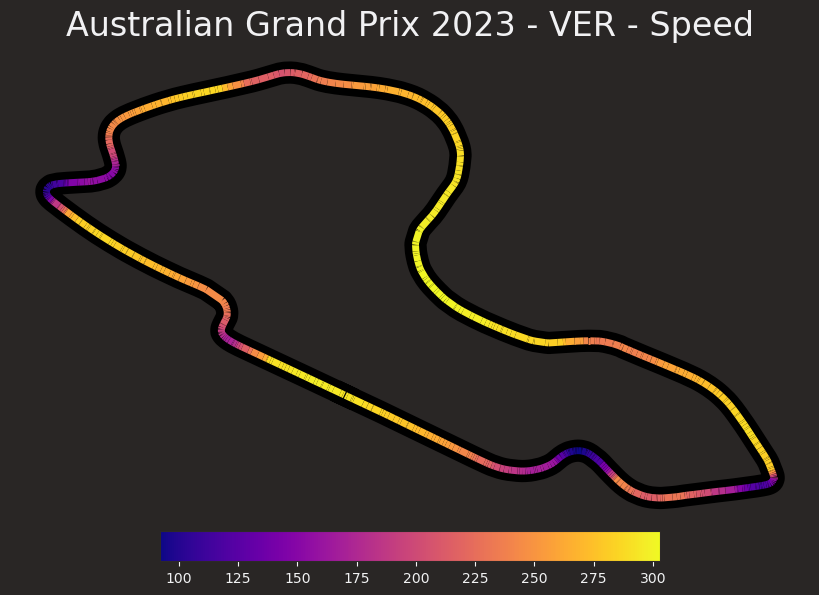

In [35]:
# We create a plot with title and adjust some setting to make it look good.
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(10, 6))
fig.suptitle(f'{weekend.name} {year} - {driver} - Speed', size=24, y=0.97)

# Adjust margins and turn of axis
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
ax.axis('off')


# After this, we plot the data itself.
# Create background track line
ax.plot(lap.telemetry['X'], lap.telemetry['Y'], color='black', linestyle='-', linewidth=16, zorder=0)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(color.min(), color.max())
lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle='-', linewidth=5)

# Set the values used for colormapping
lc.set_array(color)

# Merge all line segments together
line = ax.add_collection(lc)


# Finally, we create a color bar as a legend.
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
normlegend = mpl.colors.Normalize(vmin=color.min(), vmax=color.max())
legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=colormap, orientation="horizontal")


# Show the plot
plt.show()
# Save the plot
#plt.savefig('speed.jpg')

#### Cambios de marchas de Sergio Pérez durante el recorrido del circuito

In [19]:
session = fastf1.get_session(2023, 'Australia', 'R')
session.load()

lap = session.laps.pick_fastest()
tel = lap.get_telemetry()

core           INFO 	Loading data for Australian Grand Prix - Race [v2.3.2]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '14', '18', '11', '4', '27', '81', '24', '22', '77', '55', '10', '31', '21', '2', '20', '63', '23', '16']


In [20]:
x = np.array(tel['X'].values)
y = np.array(tel['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
gear = tel['nGear'].to_numpy().astype(float)

In [21]:
cmap = cm.get_cmap('Paired')
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(gear)
lc_comp.set_linewidth(4)

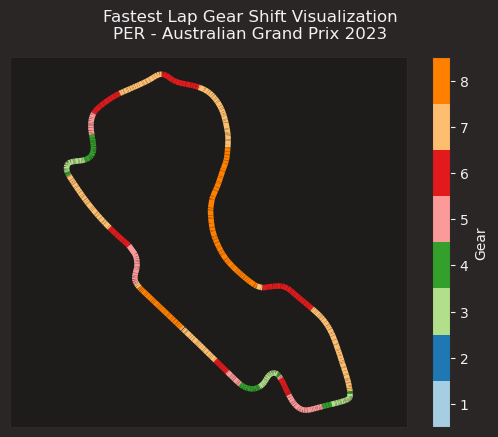

In [22]:
plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

title = plt.suptitle(
    f"Fastest Lap Gear Shift Visualization\n"
    f"{lap['Driver']} - {session.event['EventName']} {session.event.year}")

cbar = plt.colorbar(mappable=lc_comp, label="Gear", boundaries=np.arange(1, 10))
cbar.set_ticks(np.arange(1.5, 9.5))
cbar.set_ticklabels(np.arange(1, 9))


plt.show()

#### Superposición de trazas de velocidad de las vueltas rápidas de ambos pilotos

In [23]:
# enable some matplotlib patches for plotting timedelta values and load
# FastF1's default color scheme
fastf1.plotting.setup_mpl()

# load a session and its telemetry data
session = fastf1.get_session(2023, 'Australia', 'R')
session.load()

core           INFO 	Loading data for Australian Grand Prix - Race [v2.3.2]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '14', '18', '11', '4', '27', '81', '24', '22', '77', '55', '10', '31', '21', '2', '20', '63', '23', '16']


#### Seleccionamos los dos pilotos que queremos estudiar

In [24]:
ver_lap = session.laps.pick_driver('VER').pick_fastest()
per_lap = session.laps.pick_driver('PER').pick_fastest()

#### A continuación, obtenemos los datos de telemetría de cada vuelta. También agregamos una columna "Distancia" al marco de datos de telemetría, ya que esto facilita la comparación de las vueltas rápidas

In [25]:
ver_tel = ver_lap.get_car_data().add_distance()
per_tel = per_lap.get_car_data().add_distance()

#### Finalmente, creamos una gráfica y trazamos ambas trazas de velocidad. Coloreamos las líneas individuales con colores aleatorios ya que los dos pilotos son del mismo equipo

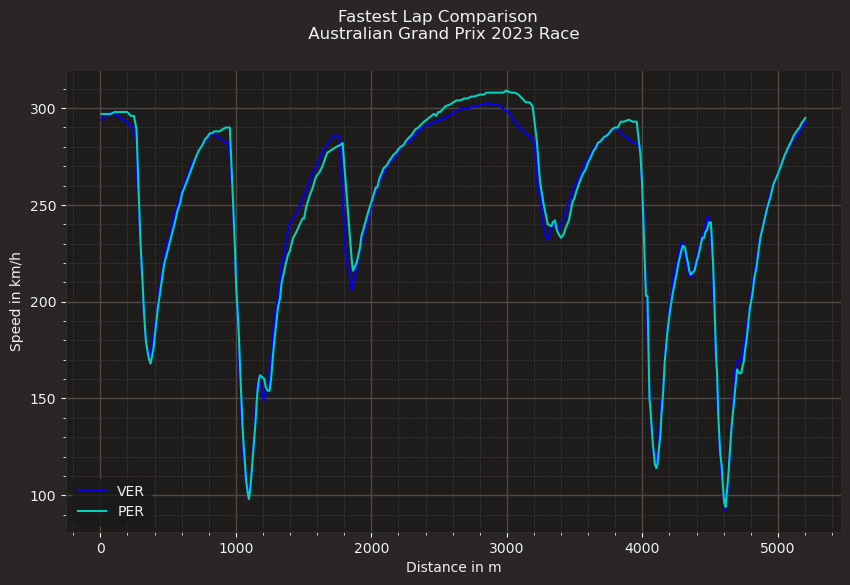

In [26]:
rbr_color = fastf1.plotting.team_color('RBR')
mer_color = fastf1.plotting.team_color('MER')

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ver_tel['Distance'], ver_tel['Speed'], color=rbr_color, label='VER')
ax.plot(per_tel['Distance'], per_tel['Speed'], color=mer_color, label='PER')

ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')

ax.legend()
plt.suptitle(f"Fastest Lap Comparison \n "
             f"{session.event['EventName']} {session.event.year} Race")

plt.show()

#### La superioridad de Pérez durante su vuelta rápida es evidente, pero, ¿pudo mantenerse al mismo nivel durante toda la carrera?

In [27]:
# Volvemos a seleccionar a los dos pilotos
laps_drive1 = laps_r.pick_driver('PER')
laps_drive2 = laps_r.pick_driver('VER')

In [28]:
# ¿Completaron todas las vueltas?
print(laps_drive1['LapNumber'].max())
print(laps_drive2['LapNumber'].max())

58.0
58.0


#### Análisis del tiempo de carrera de ambos pilotos en el total de vueltas

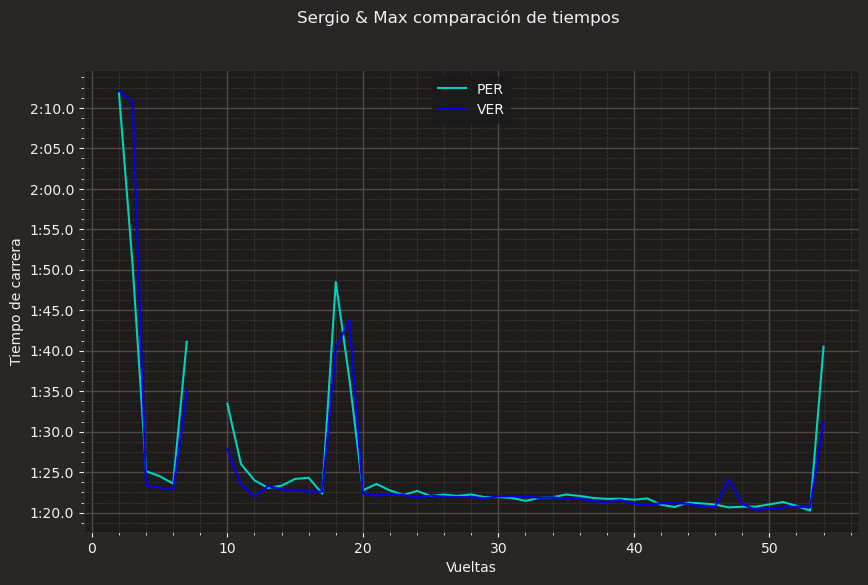

In [29]:
plt.rcParams['figure.figsize'] = [10, 6]

fig, ax = plt.subplots()
fig.suptitle(race.get_driver("PER").name + " & "+ race.get_driver("VER").name + " comparación de tiempos")

ax.plot(laps_drive1['LapNumber'], laps_drive1['LapTime'], color=mer_color, label='PER')
ax.plot(laps_drive2['LapNumber'], laps_drive2['LapTime'], color=rbr_color, label='VER')
ax.set(ylabel='Tiempo de carrera', xlabel='Vueltas')
ax.legend(loc="upper center")

plt.show()


En esta gráfica podemos observar la estabilidad de Verstappen frente a los altibajos de Pérez y ese último 'apretón' entre las vueltas 46 y 48 que lo hizo superar a su compañero de escudería. Profundizamos con más detalles de la telemetría

#### Comprobamos si en las últimas vueltas Verstappen llevaba un ritmo alto de carrera en comparación con Pérez

In [30]:
#Seleccionamos una de las últimas vueltas de nuestros pilotos
ver_lap = laps_r.pick_driver('VER')
per_lap = laps_r.pick_driver('PER')

In [31]:
per_lastlap=per_lap[per_lap.LapNumber==54]
ver_lastlap=ver_lap[ver_lap.LapNumber==54]

In [32]:
print(f'Tiempo de la vuelta 54 de Pérez: ',per_lastlap.LapTime)
print(f'Tiempo de la vuelta 54 de Verstappen: ',ver_lastlap.LapTime)

Tiempo de la vuelta 54 de Pérez:  285   0 days 00:01:40.500000
Name: LapTime, dtype: timedelta64[ns]
Tiempo de la vuelta 54 de Verstappen:  53   0 days 00:01:31.178000
Name: LapTime, dtype: timedelta64[ns]


Max Verstappen supo mantenerse a un ritmo muy alto mientras el final de carrera se acercaba

#### Finalmente y para validar nuestro estudio realizamos una última comparativa con datos de telemetría:
- Superposición de trazas de velocidad, frenos y aceleración de ambos pilótos en las últimas vueltas:


In [33]:
# Obtenemos los datos de telemetría de cada vuelta. 
ver_tel = ver_lastlap.get_car_data().add_distance()
per_tel = per_lastlap.get_car_data().add_distance()

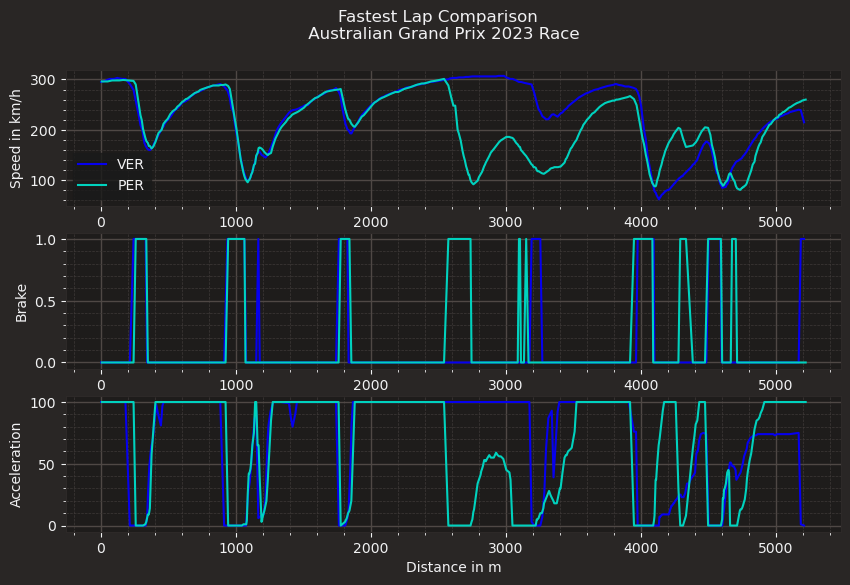

In [34]:
rbr_color = fastf1.plotting.team_color('RBR')
mer_color = fastf1.plotting.team_color('MER')

plt.rcParams['figure.figsize'] = [10, 6]
fig, ax = plt.subplots(3)

fig.suptitle("Fastest Race Lap Telemetry Comparison")

ax[0].plot(ver_tel['Distance'], ver_tel['Speed'], color=rbr_color, label='VER')
ax[0].plot(per_tel['Distance'], per_tel['Speed'], color=mer_color, label='PER')
ax[0].set_xlabel('Distance in m')
ax[0].set_ylabel('Speed in km/h')
ax[0].legend()

ax[1].plot(ver_tel['Distance'], ver_tel['Brake'], color=rbr_color, label='VER')
ax[1].plot(per_tel['Distance'], per_tel['Brake'], color=mer_color, label='PER')
ax[1].set_xlabel('Distance in m')
ax[1].set_ylabel('Brake')

ax[2].plot(ver_tel['Distance'], ver_tel['Throttle'], color=rbr_color, label='VER')
ax[2].plot(per_tel['Distance'], per_tel['Throttle'], color=mer_color, label='PER')
ax[2].set_xlabel('Distance in m')
ax[2].set(ylabel='Acceleration')

plt.suptitle(f"Fastest Lap Comparison \n "
             f"{race.weekend.name} {race.weekend.year} Race")

plt.show()

Verstappen superó a Sergio Pérez en todos los aspectos que determinan quien se alza con la victoria en un Gran Premio, no solo supo mantener un gran ritmo de carrera hacia las vueltas finales, situación que su rival no supo mantener, sino que también según los datos de telemetría extraídos de su vehículo, podemos observar una gran velocidad punta durante mayor número de metros recorridos, menor número de frenadas sobre distancias más cortas, y unos picos de aceleración mucho más constantes y extendidos que su rival. A pesar de ser Sergio Pérez el piloto más rapido de la parrilla, superando durante una de las vueltas la velocidad del experimentado Max Verstappen, no fue determinante en carrera y dicha situación acabó relegando al piloto Mexicano al quinto puesto viéndose superado por su compañero de equipo.

#### Referencias
   - https://theoehrly.github.io/Fast-F1/#